# Dataset and DataLoader

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5,))]
)

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform,download = True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download = True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle  Boot')

print('Training set has {} istances'.format(len(training_set)))
print('Validation set has {} istances'.format(len(validation_set)))

Training set has 60000 istances
Validation set has 10000 istances


Shirt   Bag   Dress   Bag


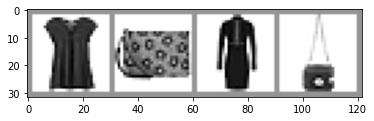

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()


img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

print('   '.join(classes[labels[j]] for j in range(4)))

# 모델

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class GarmentClassifier(nn.Module):
  def __init__(self):
    super(GarmentClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = GarmentClassifier()

# Loss Function

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.rand(4, 10)
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.0647, 0.1032, 0.3359, 0.7669, 0.9121, 0.1766, 0.8681, 0.8942, 0.7257,
         0.5625],
        [0.5228, 0.0060, 0.4858, 0.5837, 0.6697, 0.0700, 0.3184, 0.6241, 0.1267,
         0.6528],
        [0.2109, 0.0732, 0.1156, 0.3341, 0.0977, 0.2934, 0.2000, 0.5783, 0.3958,
         0.6367],
        [0.6609, 0.8222, 0.1616, 0.2194, 0.9684, 0.2691, 0.7157, 0.5241, 0.4359,
         0.3410]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.5153450965881348


In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [14]:
def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0.
  last_loss = 0.

  for i, data in enumerate(training_loader):
    inputs, labels = data

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = loss_fn(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000
      print('   batch {} loss: {}'.format(i + 1, last_loss))
      tb_x = epoch_index * len(training_loader)
      tb_writer.add_scalar('Loss/train', last_loss, tb_x)
      running_loss = 0.

    return last_loss

# Epoch Activity

In [17]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
  print('EPOCH {}:'.format(epoch_number + 1))

  model.train(True)
  avg_loss = train_one_epoch(epoch_number, writer)

  model.train(False)

  running_vloss = 0.0
  for i, vdata in enumerate(validation_loader):
    vinputs, vlabels = vdata
    voutputs = model(vinputs)
    vloss = loss_fn(voutputs, vlabels)
    running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

  writer.add_scalars('Training vs. Validation Loss', {'Training' : avg_loss, 'Validation' : avg_vloss },
                     epoch_number + 1)
  
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

  epoch_number += 1

EPOCH 1:
LOSS train 0.0 valid 2.3080756664276123
EPOCH 2:
LOSS train 0.0 valid 2.3080263137817383
EPOCH 3:
LOSS train 0.0 valid 2.3079915046691895
EPOCH 4:
LOSS train 0.0 valid 2.3079605102539062
EPOCH 5:
LOSS train 0.0 valid 2.3079307079315186


In [19]:
# 모델 불러오기
# saved_model = GarmentClassifier()
# saved_model.load_state_dict(torch.load(PATH))